# LSTM emotion recognizer

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00


Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [4]:
from datasets import load_dataset
emotions = load_dataset('emotion')
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print('Maximum text length: {}'.format(max_textlen))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Maximum text length: 66


Create the training and test datasets.

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_label = tf.keras.utils.to_categorical(emotions['train']['label'], 6)

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_label = tf.keras.utils.to_categorical(emotions['validation']['label'], 6)

emotion_labels = emotions['train'].features['label'].names

In [6]:
train_text[0]

array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [7]:
train_label[0]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

Define the bidirectional LSTM model.

In [8]:
lstm_model = models.Sequential(name='Bidirectional_LSTM_classifier')
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, input_shape=(None,),
                                name='text_embedding'))
lstm_model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True),
                                    name='bidirectional_LSTM1'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=False),
                                    name='bidirectional_LSTMs'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(1024, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))
lstm_model.summary()

Model: "Bidirectional_LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 bidirectional_LSTM1 (Bidire  (None, None, 1024)       4198400   
 ctional)                                                        
                                                                 
 dropout1 (Dropout)          (None, None, 1024)        0         
                                                                 
 bidirectional_LSTMs (Bidire  (None, 512)              2623488   
 ctional)                                                        
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 feedforward (Dense)         (None, 1

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [9]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=16, epochs=8)

Epoch 1/8
1000/1000 [==============================] - 110s 91ms/step - loss: 1.3575 - acc: 0.4575 - val_loss: 0.7969 - val_acc: 0.7050
Epoch 2/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.5494 - acc: 0.7897 - val_loss: 0.4630 - val_acc: 0.8455
Epoch 3/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.2794 - acc: 0.9028 - val_loss: 0.3915 - val_acc: 0.8675
Epoch 4/8
1000/1000 [==============================] - 63s 63ms/step - loss: 0.1681 - acc: 0.9414 - val_loss: 0.3657 - val_acc: 0.8850
Epoch 5/8
1000/1000 [==============================] - 62s 62ms/step - loss: 0.1257 - acc: 0.9576 - val_loss: 0.4218 - val_acc: 0.8765
Epoch 6/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0953 - acc: 0.9679 - val_loss: 0.3807 - val_acc: 0.8965
Epoch 7/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0797 - acc: 0.9739 - val_loss: 0.3506 - val_acc: 0.8975
Epoch 8/8
1000/1000 [==============================] -

Plot charts for the accuracy and loss values.

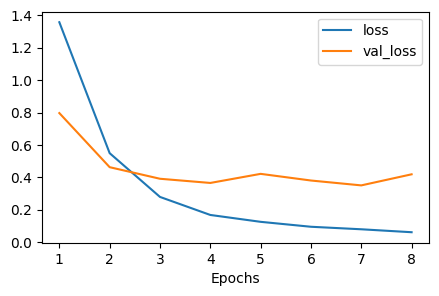

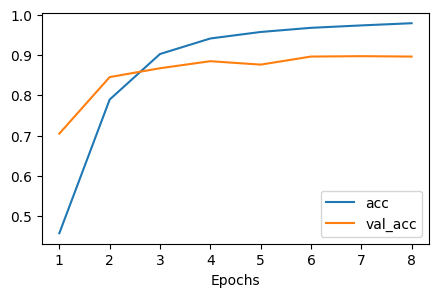

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

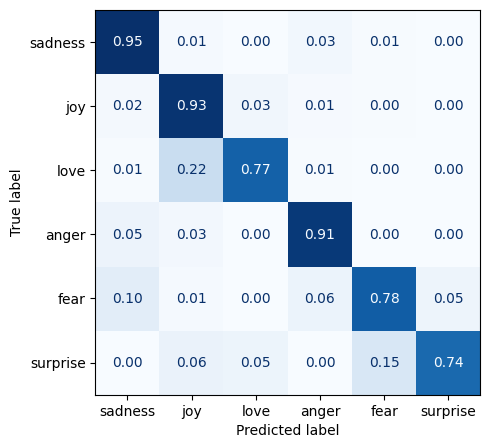

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = lstm_model.predict(test_text, verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

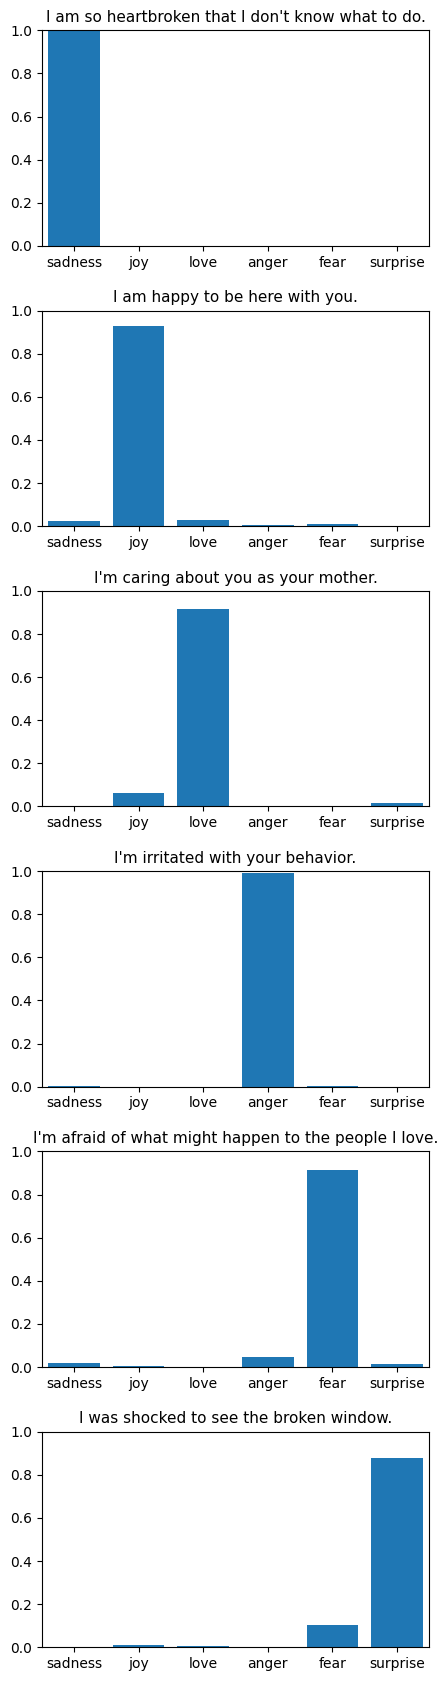

In [13]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])

predictions = lstm_model.predict(input_ids, verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(5, 3.5*n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')